# CISSM.
El archivo CSV contiene información sobre incidentes de ciberataques, con detalles sobre la fecha del evento, los actores involucrados, el tipo de evento, la organización afectada, el tipo de industria, la fuente del evento, el país, el motivo y el tipo de ataque.

## Importación de librerías.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Importación e información de dataframes

In [2]:
df = pd.read_csv('./data/CISSM.csv')
df

,event_description,event_date,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,id,dnx_id,date_uploaded
0,"Innovery, an Italian company delivering IT ser...",2023-09-30,Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,f5c2ebc02807a6b3,inc_cis_13422,2024-04-01
1,The ALPHV/BlackCat ransomware gang adds the ho...,2023-09-30,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,0b7a20f4161d89b2,inc_cis_13421,2024-04-01
2,The pro-Russian collective NoName057(16) takes...,2023-09-29,NoName057(16),Hacktivist,Disruptive,Multiple organizations in Italy,External Denial of Service,Protest,https://www.redhotcyber.com/post/si-ricomincia...,ITA,Public Administration,92.0,2e37d07ef6ef3cb6,inc_cis_13420,2024-04-01
3,API Financial Solutions files a notice of data...,2023-09-29,Undetermined,Criminal,Exploitive,API Financial Solutions,Undetermined,Financial,https://www.jdsupra.com/legalnews/api-financia...,USA,Finance and Insurance,52.0,f8029e6b6169de1f,inc_cis_13419,2024-04-01
4,"McLaren HealthCare, confirms to be dealing wit...",2023-09-29,ALPHV,Criminal,Mixed,McLaren HealthCare,"Data Attack,Undetermined",Financial,https://therecord.media/mclaren-healthcare-ran...,USA,Health Care and Social Assistance,62.0,1ed93f0579b9056c,inc_cis_13418,2024-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,Erlanger Health is also affected by the MOVEit...,2023-09-27,Qilin,Criminal,Mixed,Cardiovascular Consultants,Exploitation of Application Server,Financial,https://www.databreaches.net/cardiovascular-co...,USA,Health Care and Social Assistance,62.0,c823006f6c70313c,inc_cis_4,2024-04-01
13419,The European Telecommunications Standards Inst...,2023-09-27,cl0p,Criminal,Exploitive,Erlanger Health,Exploitation of Application Server,Financial,https://www.hipaajournal.com/oak-valley-hospit...,USA,Health Care and Social Assistance,62.0,c886a43fe79a0a7b,inc_cis_3,2024-04-01
13420,Lost Trust Team adds GI Medical Services in Ne...,2023-09-27,Undetermined,Criminal,Exploitive,European Telecommunications Standards Institut...,Exploitation of Application Server,Undetermined,https://therecord.media/etsi-telecommunication...,FRA,Information,51.0,bb17aacdf2e20d25,inc_cis_2,2024-04-01
13421,"UK charities including Shelter, the RSPCA, the...",2023-09-27,Lost Trust,Criminal,Exploitive,GI Medical Services,Undetermined,Financial,https://www.databreaches.net/and-yet-more-vict...,USA,Health Care and Social Assistance,62.0,bac11292d79231f0,inc_cis_1,2024-04-01


Debemos de tomar la columna ID como índice.

In [3]:
df.set_index('id', inplace=True)

In [4]:
df.describe()

,event_description,event_date,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,date_uploaded
count,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423
unique,11646,3126,1163,7,5,12202,95,13,10724,164,22,26,13423,1
top,Vice Society encrypts network and threatens to...,2017-06-27,Undetermined,Criminal,Exploitive,Undetermined,Exploitation of Application Server,Financial,https://stniiomyjliimcgkvdszvgen3eaaoz55hreqqx...,USA,Public Administration,92.0,inc_cis_13422,2024-04-01
freq,97,78,7639,10181,6676,56,4314,7533,73,6459,2518,2518,1,13423


In [5]:
df.shape

(13423, 14)

In [6]:
df.dtypes

event_description    object
event_date           object
actor                object
actor_type           object
event_type           object
organization         object
event_subtype        object
motive               object
event_source         object
country              object
industry             object
industry_code        object
dnx_id               object
date_uploaded        object
dtype: object

In [7]:
df['industry_code'] = pd.to_numeric(df['industry_code'], errors='coerce')

In [8]:
df.columns

Index(['event_description', 'event_date', 'actor', 'actor_type', 'event_type',
       'organization', 'event_subtype', 'motive', 'event_source', 'country',
       'industry', 'industry_code', 'dnx_id', 'date_uploaded'],
      dtype='object')

A continuación, se incluye una breve explicación sobre la información que aporta cada columna.
1. **ID**: Un identificador único para cada incidente de ciberataque.
2. **Event Description**: Descripción detallada del incidente, explicando qué ocurrió durante el ataque.
3. **Event Date**: Fecha en la que ocurrió el evento o ataque.
4. **Actor**: La entidad o grupo responsable del ataque.
5. **Actor Type**: El tipo de actor responsable del ataque, como "Criminal" o "Estado".
6. **Event Type**: Tipo de ataque realizado, como "Exploitive" o "Data Attack".
7. **Organization**: La organización o empresa que fue el objetivo del ataque.
8. **Event Subtype**: Subtipo del evento que describe más específicamente el ataque.
9. **Motive**: Razón o motivo detrás del ataque, por ejemplo, "Financial" si el objetivo es económico.
10. **Event Source**: Fuente de información sobre el evento, generalmente un enlace a un artículo o informe.
11. **Country**: País donde ocurrió el ataque o donde está ubicada la organización objetivo.
12. **Industry**: Sector o industria al que pertenece la organización atacada.
13. **Industry Code**: Código numérico que representa el sector o industria de la organización.
14. **DNX ID**: Un identificador adicional del incidente dentro del sistema de la base de datos.
15. **Date Uploaded**: La fecha en que la información sobre el incidente fue subida al sistema o base de datos.

In [9]:
df.head(3)

,event_description,event_date,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,date_uploaded
id,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",2023-09-30,Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2024-04-01
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,2023-09-30,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2024-04-01
2e37d07ef6ef3cb6,The pro-Russian collective NoName057(16) takes...,2023-09-29,NoName057(16),Hacktivist,Disruptive,Multiple organizations in Italy,External Denial of Service,Protest,https://www.redhotcyber.com/post/si-ricomincia...,ITA,Public Administration,92.0,inc_cis_13420,2024-04-01


In [10]:
df['event_date'] = pd.to_datetime(df['event_date'])

In [11]:
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day

In [12]:
df.drop('event_date', axis = 1, inplace = True)

In [13]:
df.head(2)

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,date_uploaded,year,month,day
id,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2024-04-01,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2024-04-01,2023,9,30


## Limpieza de datos.
A simple vista, podemos detectar algunas columnas que no aportarán información para la identificación de patrones de ciberataques. La fecha en que la información fue subida al sistema no es relevante para el análisis de los incidentes en sí, ya que no afecta la naturaleza o el impacto del ataque, **Date Uploaded**. Finalmente, la columna **Industry** puede parecer importante, pero se elimina ya que existe otra en la que está representada por el código de la industria.

In [14]:
df.drop(['date_uploaded'], axis = 1, inplace = True)

### Manejo de filas duplicadas.
En caso de haber filas duplicadas, deberemos de eliminar estas para que no afecten al análisis posterior.

In [15]:
df.duplicated().sum() # Columnas duplicadas

0

In [16]:
df.drop_duplicates(inplace = True)

In [17]:
df.shape

(13423, 15)

### Manejo de filas nulas.

In [18]:
df.isnull().sum() # Valores nulos

event_description     0
actor                 0
actor_type            0
event_type            0
organization          0
event_subtype         0
motive                0
event_source          0
country               0
industry              0
industry_code        22
dnx_id                0
year                  0
month                 0
day                   0
dtype: int64

In [19]:
df.dropna(inplace = True)

Al examinar detenidamente el DataFrame, notamos que hay algunas columnas que no están marcadas como valores nulos, pero que contienen el texto `'[]'`, lo que indica que son valores vacíos. Es necesario revisar estas filas para determinar cómo manejarlas.

Después de esta revisión, concluimos que las filas afectadas son bastante pocas en comparación con el total de filas en el DataFrame original. Por lo tanto, la mejor opción sería eliminarlas.

In [20]:
(df == '[]').sum()

event_description     3
actor                 0
actor_type            0
event_type            0
organization          0
event_subtype        21
motive                1
event_source          4
country               8
industry              0
industry_code         0
dnx_id                0
year                  0
month                 0
day                   0
dtype: int64

In [21]:
df.drop(df[(df == '[]').any(axis=1)].index, inplace=True)

In [22]:
df.shape

(13364, 15)

### Selección de variables categóricas y continuas.
Para realizar correctamente un ánalisis de datos debemos de distinguir entre las variables categóricas, variables que representan diferentes categorías o grupos, y continuas, variables que pueden tomar cualquier valor dentro de un rango determinado.

In [23]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if df[i].nunique() > 25 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: event_description, actor, organization, event_subtype, event_source, country, industry_code, dnx_id, year, month, day
Variables categóricas: actor_type, event_type, motive, industry


#### Tratamiento de variables categóricas.
Para el posterior modelo de clasificación, necesitamos codificar nuestras variables. Para ello, realizaremos una codificación ordinal que consiste en asignar valores enteros a las categorias basándose en su posición o jerarquía en los datos.

In [24]:
df[v_categoricas].head(3)

,actor_type,event_type,motive,industry
id,,,,
f5c2ebc02807a6b3,Criminal,Exploitive,Financial,"Professional, Scientific, and Technical Services"
0b7a20f4161d89b2,Criminal,Mixed,Financial,Accommodation and Food Services
2e37d07ef6ef3cb6,Hacktivist,Disruptive,Protest,Public Administration


In [25]:
df[v_categoricas].nunique()

actor_type     7
event_type     5
motive        11
industry      21
dtype: int64

##### **Industry.**
Esta columna ya viene codificada a través de **Industry Code**. Guardámos la columna para saber a que corresponde cada una.

In [26]:
df['industry'].nunique()

21

In [27]:
df['industry_code'].nunique()

25

##### **Event Type.**

In [28]:
df['event_type'].unique()

array(['Exploitive', 'Mixed', 'Disruptive', 'Undetermined',
       'Exploitation of Application Server'], dtype=object)

Los valores **Exploitive** y **Exploitation of Application Server** están relacionados con la explotación de vulnerabilidades, ya sea de manera general o específica (como en un servidor de aplicaciones). Por ello los juntaremos en la misma categoria.

In [29]:
df['event_type'].replace('Exploitation of Application Server', 'Exploitive', inplace=True)

Cuando trabajamos con variables categóricas, como en este caso con la columna 'event_type' que tiene valores como **Exploitive**, **Disruptive**, **Mixed** y **Undetermined**, se suele utilizar la técnica de **One-hot encoder** para convertir estas categorías en variables binarias que un modelo de Machine Learning pueda entender. El objetivo es crear una columna para cada categoría con valores 0 o 1, indicando si un evento pertenece a esa categoría o no.

El valor **Mixed** es especial porque representa una combinación de dos categorías: **Exploitive** y **Disruptive**. Esto significa que cuando un evento está clasificado como **Mixed**, en realidad debe ser tratado como si fuera tanto **Exploitive** como **Disruptive**. Añadiendo un 1 en cada columna de estos.

In [30]:
dummies = pd.get_dummies(df['event_type'])
dummies['Exploitive'] = dummies['Exploitive'] | dummies['Mixed']
dummies['Disruptive'] = dummies['Disruptive'] | dummies['Mixed']

df = pd.concat([df, dummies], axis=1)
df.drop(['Mixed'], axis=1, inplace=True)

In [31]:
df.head(2)

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,year,month,day,Disruptive,Exploitive,Undetermined
id,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2023,9,30,0,1,0
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2023,9,30,1,1,0


##### **Organization**

Marcamos la frecuencia (`organization_freq`) con la que las organizaciones son atacadas

In [32]:
# Calcular la frecuencia relativa de cada organización
df['organization_freq'] = df['organization'].map(df['organization'].value_counts(normalize=True))

print(df['organization_freq'].head(3))



id
f5c2ebc02807a6b3    0.000150
0b7a20f4161d89b2    0.000150
2e37d07ef6ef3cb6    0.000224
Name: organization_freq, dtype: float64


##### **Motive**

In [33]:
df['motive'].unique()

array(['Financial', 'Protest', 'Undetermined', 'Political-Espionage',
       'Sabotage', 'Espionage', 'Espionage-Political', 'Sabatoge',
       'Personal Attack', 'Protest,Financial', 'Industrial-Espionage'],
      dtype=object)

Debemos de arreglar fallos de escritura primero. En nuestro conjunto de datos, encontramos entradas como **Sabatoge**, que son errores de escritura y deben corregirse a **Sabotage**. Estas correcciones aseguran que todos los datos sean consistentes y que no haya duplicados causados por errores de escritura.

In [34]:
df['motive'] = df['motive'].str.replace('Espionage-Political', 'Political-Espionage')
df['motive'] = df['motive'].str.replace('Sabatoge', 'Sabotage')

Es importante agrupar categorías que representan la misma amenaza. Por ejemplo, las categorías **Industrial-Espionage** y **Political-Espionage** pueden ser agrupadas bajo una sola categoría: **Espionage**. Esta agrupación ayuda a simplificar el análisis, permitiendo que se obtengan conclusiones más claras y significativas.

In [35]:
motive_mapping = {
    'Political-Espionage': 'Espionage',
    'Industrial-Espionage': 'Espionage',
}

# Aplicamos la agrupación
df['motive'] = df['motive'].replace(motive_mapping)

In [36]:
df['motive'].unique()

array(['Financial', 'Protest', 'Undetermined', 'Espionage', 'Sabotage',
       'Personal Attack', 'Protest,Financial'], dtype=object)

En el proceso de limpieza de datos, es posible que se detecten casos donde una fila contenga múltiples categorías que deberían ser exclusivas. En nuestro conjunto de datos, hemos encontrado un caso donde una entrada presenta simultáneamente las categorías **Protest** y **Financial**. Sin embargo, dado que esta situación ocurre solo en una fila de aproximadamente 13000 registros, podemos prescindir de este caso sin afectar significativamente el análisis general.

In [37]:
df.drop(df[df['motive'] == 'Protest,Financial'].index, inplace=True) # solo es una fila, por no hacer get_dummies

In [38]:
df['motive'].unique()

array(['Financial', 'Protest', 'Undetermined', 'Espionage', 'Sabotage',
       'Personal Attack'], dtype=object)

In [39]:
encoder = OrdinalEncoder()
df.insert(df.columns.get_loc('motive') + 1, 'motive_code', encoder.fit_transform(df[['motive']]))
df.head(2)

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,motive_code,event_source,country,industry,industry_code,dnx_id,year,month,day,Disruptive,Exploitive,Undetermined,organization_freq
id,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,1.0,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2023,9,30,0,1,0,0.00015
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,1.0,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2023,9,30,1,1,0,0.00015


##### **Actor Type.**
Debemos examinar cuidadosamente esta columna para determinar si es posible realizar la codificación ordinal. Como se observa, hay un valor que aparece como `Undeterminated` y otro valor de `Criminal` que está mal escrito en una de las entradas.

In [40]:
df['actor_type'] = df['actor_type'].str.replace('Criminal', 'Criminal', regex=True)
df['actor_type'].unique()

array(['Criminal', 'Hacktivist', 'Nation-State', 'Undetermined',
       'Hobbyist', 'Crimimal', 'Terrorist'], dtype=object)

In [41]:
df['actor_type'] = df['actor_type'].str.replace('Criminal', 'Criminal', regex=True)


In [42]:
df['actor_type'].unique()

array(['Criminal', 'Hacktivist', 'Nation-State', 'Undetermined',
       'Hobbyist', 'Crimimal', 'Terrorist'], dtype=object)

In [43]:
encoder = OrdinalEncoder()
df['actor_type'] = encoder.fit_transform(df[['actor_type']])
df.head(2)

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,motive_code,event_source,country,industry,industry_code,dnx_id,year,month,day,Disruptive,Exploitive,Undetermined,organization_freq
id,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,1.0,Exploitive,Innovery,Exploitation of Application Server,Financial,1.0,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2023,9,30,0,1,0,0.00015
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,1.0,Mixed,Motel One,"Data Attack,Undetermined",Financial,1.0,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2023,9,30,1,1,0,0.00015


##### **Actor**

Codificamos con label encoding Actor 
`Actor_encoded` representa el codigo de el individuo o grupo que llevo a cabo el ciberataque

In [44]:
# Codificación de actor

# Label Encoding
df['actor_encoded'] = df['actor'].astype('category').cat.codes

# Verificar los valores codificados
print(df[['actor', 'actor_encoded']].head())

print (df.shape)

# Verificar si los valores en 'actor_encoded' corresponden a los de 'actor'
actor_mapping = dict(zip(df['actor'], df['actor_encoded']))
print("Mapping de Actor a Actor Encoded:")
print(actor_mapping)

# Verificar ejemplos específicos
print(df[['actor', 'actor_encoded']].drop_duplicates().head(10))  # Comparar valores únicos


                          actor  actor_encoded
id                                            
f5c2ebc02807a6b3   Undetermined           1041
0b7a20f4161d89b2          ALPHV             55
2e37d07ef6ef3cb6  NoName057(16)            720
f8029e6b6169de1f   Undetermined           1041
1ed93f0579b9056c          ALPHV             55
(13363, 21)
Mapping de Actor a Actor Encoded:
{'Undetermined': 1041, 'ALPHV': 55, 'NoName057(16)': 720, 'Medusa': 627, 'Ukrainian IT Army': 1038, 'Cl0p': 254, 'Indian Cyber Force': 503, 'CACTUS': 230, 'Lost Trust': 604, 'Dark Angels': 319, 'RansomedVC': 822, 'RansomedVC or MajorNelson?': 823, 'Rhysida': 838, 'ADHD': 52, 'NoEscape': 719, 'Vice Society': 1058, 'Cyber Avengers': 285, '8BASE': 11, 'ThreeAM (AKA 3AM)': 987, 'LockBit 3.0': 596, 'Sylhet Gang': 934, 'Akira': 84, 'NGB 3rd Technical Surveillance Bureau': 690, 'Ransom House': 817, 'Snatch and Nokoyawa': 909, 'Anonymous Sudan': 148, 'ALPHVM': 56, 'Hacktivist Indonesia': 461, 'BianLian': 191, 'USDoD': 1031, '

#### Tratamiento de variables continuas.
Para el modelo de clasificación debemos de pasar todas las columnas a tipo `int`. Por ello, debemos de ver si realizar como en el caso anterior una codificación ordinal o agruparlos.

In [45]:
df[v_continuas].head(2)

,event_description,actor,organization,event_subtype,event_source,country,industry_code,dnx_id,year,month,day
id,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Innovery,Exploitation of Application Server,https://www.redhotcyber.com/post/attacco-infor...,ITA,54.0,inc_cis_13422,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Motel One,"Data Attack,Undetermined",https://securityaffairs.com/151732/cyber-crime...,DEU,72.0,inc_cis_13421,2023,9,30


In [46]:
v_categoricas_cont = list(df[v_continuas].dtypes[df[v_continuas].dtypes == 'object'].index)
v_categoricas_cont.remove('dnx_id')

In [47]:
df[v_categoricas_cont].nunique()

event_description    11591
actor                 1161
organization         12150
event_subtype           93
event_source         10687
country                163
dtype: int64

##### **Event Subtype.**

In [48]:
df['event_subtype'].unique()

array(['Exploitation of Application Server', 'Data Attack,Undetermined',
       'External Denial of Service', 'Undetermined',
       'Exploitation of Application Server,Data Attack',
       'Exploitation of End User', 'Exploitation of Infrastructure',
       'Message Manipulation', 'Data Attack,Exploitation of End User',
       'Exploitation of End Host', 'External Denial of Services',
       'Data Attack,Exploitation of End Host', 'Data Attack',
       'Physical Attack', 'Physical Attack,Undetermined',
       'Exploitation of Applilcation Server', 'Exploitation of Sensor',
       'Internal Denial of Service', 'Exploitation of Sensors',
       'Exploitation of Applicatoin Server',
       'Exploitation of Data in Transit',
       'Exploitation of Application Server,Message Manipulation',
       'Exploitation of Network Infrastructure',
       'Exploitation of Network Infrastrucutre',
       'Exploitation of Application Server,Data Attack,Internal Denial of Service',
       'Exploitation

**Corrección de escritura.**

In [49]:
df['event_subtype'] = df['event_subtype'].str.replace('Exploittation of Application Server', 'Exploitation of Application Server')

##### **Country.**
Para realizar una evaluación más efectiva de los países en nuestros datos, es conveniente agruparlos por continentes. Esto es especialmente relevante porque en otros archivos CSV hay registros de ataques provenientes de diferentes países, distribuidos en distintos continentes.

Para facilitar este análisis, procederemos a crear seis nuevas columnas en nuestro conjunto de datos, cada una representando un continente específico. Estas columnas indicarán con un valor de 1 si el país pertenece al continente correspondiente y 0 si no es así, es decir, mediante una asignación de valores binarios.

In [50]:
df['country'].unique()

array(['ITA', 'DEU', 'USA', 'RUS', 'CAN', 'GBR', 'FRA', 'JPN', 'UKR',
       'PHL', 'HKG', 'SGP', 'BMU', 'NZL', 'CHN', '999', 'ISR', 'BRA',
       'KWT', 'THA', 'IND', 'COL', 'LKA', 'ESP', 'AUS', 'NLD', 'TUR',
       'TWN', 'MEX', 'MAR', 'CZE', 'KOR', 'IRN', 'POL', 'BEL', 'DNK',
       'ZAF', 'CHE', 'SRB', 'SLV', 'LTU', 'ECU', 'ARG', 'IDN', 'VNM',
       'PRT', 'PAK', 'NGA', 'KEN', 'NOR', 'EGY', 'MYS', 'IRL', 'SWE',
       'FIN', 'MLT', 'BLR', 'TTO', 'MLI', 'JAM', 'EST', 'GRC', 'CHL',
       'CYM', 'HRV', 'SYC', 'VEN', 'GTM', 'CYP', 'PAN', 'CRI', 'VCT',
       'PRI', 'PER', 'DOM', 'BHR', 'TON', 'URY', 'SVK', 'LVA', 'CUB',
       'MDA', 'ARE', 'AUT', 'BRB', 'ROU', 'VAT', 'MDV', 'GLP', 'BES',
       'TGO', 'SAU', 'VUT', 'BGR', 'HUN', 'BHS', 'MMR', 'PRY', 'KAZ',
       'GHA', 'BIH', 'ALB', 'MNE', 'BOL', 'ASM', 'KIR', 'LUX', 'BGD',
       'GRL', 'ZMB', 'JOR', 'NRU', 'GIB', 'GUF', 'LBN', 'QAT', 'SVN',
       'PRK', 'AND', 'AGO', 'PNG', 'AFG', 'GEO', 'FJI', 'OMN', 'MNG',
       'NPL', 'CPV',

In [51]:
continent_mapping = {
    'Europe': ['ITA', 'DEU', 'GBR', 'FRA', 'UKR', 'ESP', 'NLD', 'POL', 'BEL', 'DNK',
               'CHE', 'SRB', 'LTU', 'MLT', 'GRC', 'CZE', 'HRV', 'HUN', 'AUT', 'SVK',
               'BLR', 'BGR', 'GIB', 'MDA', 'PRT', 'SVN', 'AND', 'LVA', 'CUB', 'KIR', 
               'RUS', 'NOR', 'SWE', 'FIN', 'EST', 'IRL', 'CYP', 'TUR', 'ROU', 'VAT',
                'MDV', 'BIH', 'ALB', 'MNE', 'LUX', 'ARM', 'IMN', 'LIE', 'MCO', 'AZE',
                'ISL', 'MKD'],
    'North America': ['USA', 'CAN', 'BMU', 'MEX', 'NIC', 'CRI', 'SLV', 'GTM', 
                      'PRI', 'TTO', 'JAM', 'BHS', 'BLZ', 'CYM', 'BRB', 'GLP',
                      'GRL'],
    'South America': ['BRA', 'ARG', 'COL', 'PER', 'VEN', 'CHL', 'URY', 'PAR', 
                      'BOL', 'ECU', 'PAN', 'VCT', 'DOM', 'BES', 'PRY', 'GUF',],
    'Asia': ['JPN', 'CHN', 'KWT', 'THA', 'IND', 'PHL', 'HKG', 'SGP', 'IDN', 
             'VNM', 'IRN', 'KOR', 'PAK', 'ISR', 'TWN', 'BGD', 'AFG', 'KHM', 
             'LAO', 'OMN', 'QAT', 'JOR', 'IRQ', 'MNG', 'UZB', 'TKM', 'YEM', 
             'MDA', 'GEO', 'FJI', 'LKA', 'TJK', 'MYS', 'BHR', 'ARE', 'SAU',
              'MMR', 'KAZ', 'LBN', 'PRK', 'NPL', 'SYR', 'LBY', 'PSE'],
    'Africa': ['ZAF', 'EGY', 'KEN', 'NGA', 'GHA', 'ETH', 'ZMB', 'UGA', 
               'DZA', 'TGO', 'MAR', 'SDN', 'SLE', 'RWA', 'AGO', 'MLI', 
               'TUN', 'ZWE', 'NAM', 'LSO', 'MZW', 'SYC', 'CPV', 'GAB',
               'MWI', 'TZA', 'SEN'],
    'Australia': ['NZL', 'AUS', 'TON', 'PNG', 'NRU', 'FJI', 'PLW', 'KIR', 'VUT', 'ASM', 'GUM']
}

In [52]:
def assign_continent(country):
    for continent, countries in continent_mapping.items():
        if country in countries:
            return continent
    return None  # Si el país no está en la lista, retornar None

In [53]:
df['country'].nunique()

163

In [54]:
df.shape

(13363, 21)

In [55]:
df['continent'] = df['country'].map(assign_continent)

In [56]:
df['continent'].unique()

array(['Europe', 'North America', 'Asia', 'Australia', None,
       'South America', 'Africa'], dtype=object)

In [57]:
countries_with_no_continent = df[df['continent'].isnull()]['country'].unique()

# Mostrar la lista de países con 'continent' como None
print("Lista de países con 'continent' como None:")
print(countries_with_no_continent)

Lista de países con 'continent' como None:
['999' 'ATA']


In [58]:
df.dropna(subset=['continent'], inplace=True)

In [59]:
df['continent'] = df['country'].apply(assign_continent)
df_continentes = pd.get_dummies(df['continent'])

df = pd.concat([df, df_continentes], axis=1)

print(df)

                                                  event_description  \
id                                                                    
f5c2ebc02807a6b3  Innovery, an Italian company delivering IT ser...   
0b7a20f4161d89b2  The ALPHV/BlackCat ransomware gang adds the ho...   
2e37d07ef6ef3cb6  The pro-Russian collective NoName057(16) takes...   
f8029e6b6169de1f  API Financial Solutions files a notice of data...   
1ed93f0579b9056c  McLaren HealthCare, confirms to be dealing wit...   
...                                                             ...   
285fa5842609a5bf  Cardiovascular Consultants (CVC Heart) is hit ...   
c823006f6c70313c  Erlanger Health is also affected by the MOVEit...   
c886a43fe79a0a7b  The European Telecommunications Standards Inst...   
bb17aacdf2e20d25  Lost Trust Team adds GI Medical Services in Ne...   
bac11292d79231f0  UK charities including Shelter, the RSPCA, the...   

                               actor  actor_type  event_type  \
id          

In [60]:
df.drop(['country', 'continent'], axis = 1, inplace = True)

In [61]:
df.head(2)

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,motive_code,event_source,industry,...,Exploitive,Undetermined,organization_freq,actor_encoded,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,1.0,Exploitive,Innovery,Exploitation of Application Server,Financial,1.0,https://www.redhotcyber.com/post/attacco-infor...,"Professional, Scientific, and Technical Services",...,1,0,0.00015,1041,0,0,0,1,0,0
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,1.0,Mixed,Motel One,"Data Attack,Undetermined",Financial,1.0,https://securityaffairs.com/151732/cyber-crime...,Accommodation and Food Services,...,1,0,0.00015,55,0,0,0,1,0,0


##### **Event Source.**
Esta columna servirá posteriormente para definir las relaciones entre CSVs. Deberemos de extraer el nombre del dominio de la URL. 

In [62]:
from urllib.parse import urlparse

# Extraer el dominio de la URL
df['event_source_domain'] = df['event_source'].fillna("").apply(lambda x: urlparse(str(x)).netloc)


In [63]:
from urllib.parse import urlparse

# Extraer el dominio de la URL
df['event_source_domain'] = df['event_source'].fillna("").apply(lambda x: urlparse(str(x)).netloc)


In [64]:
df['event_source'] = df['event_source'].str.replace('www.', '', regex=False)

In [65]:
df

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,motive_code,event_source,industry,...,Undetermined,organization_freq,actor_encoded,Africa,Asia,Australia,Europe,North America,South America,event_source_domain
id,,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,1.0,Exploitive,Innovery,Exploitation of Application Server,Financial,1.0,https://redhotcyber.com/post/attacco-informati...,"Professional, Scientific, and Technical Services",...,0,0.000150,1041,0,0,0,1,0,0,www.redhotcyber.com
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,1.0,Mixed,Motel One,"Data Attack,Undetermined",Financial,1.0,https://securityaffairs.com/151732/cyber-crime...,Accommodation and Food Services,...,0,0.000150,55,0,0,0,1,0,0,securityaffairs.com
2e37d07ef6ef3cb6,The pro-Russian collective NoName057(16) takes...,NoName057(16),2.0,Disruptive,Multiple organizations in Italy,External Denial of Service,Protest,3.0,https://redhotcyber.com/post/si-ricomincia-agc...,Public Administration,...,0,0.000224,720,0,0,0,1,0,0,www.redhotcyber.com
f8029e6b6169de1f,API Financial Solutions files a notice of data...,Undetermined,1.0,Exploitive,API Financial Solutions,Undetermined,Financial,1.0,https://jdsupra.com/legalnews/api-financial-so...,Finance and Insurance,...,0,0.000150,1041,0,0,0,0,1,0,www.jdsupra.com
1ed93f0579b9056c,"McLaren HealthCare, confirms to be dealing wit...",ALPHV,1.0,Mixed,McLaren HealthCare,"Data Attack,Undetermined",Financial,1.0,https://therecord.media/mclaren-healthcare-ran...,Health Care and Social Assistance,...,0,0.000150,55,0,0,0,0,1,0,therecord.media
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285fa5842609a5bf,Cardiovascular Consultants (CVC Heart) is hit ...,Indian Cyber Force,2.0,Disruptive,Canadian Armed Forces,External Denial of Service,Protest,3.0,https://thewire.in/world/pro-india-hacker-grou...,Public Administration,...,0,0.000150,503,0,0,0,0,1,0,thewire.in
c823006f6c70313c,Erlanger Health is also affected by the MOVEit...,Qilin,1.0,Mixed,Cardiovascular Consultants,Exploitation of Application Server,Financial,1.0,https://databreaches.net/cardiovascular-consul...,Health Care and Social Assistance,...,0,0.000075,800,0,0,0,0,1,0,www.databreaches.net
c886a43fe79a0a7b,The European Telecommunications Standards Inst...,cl0p,1.0,Exploitive,Erlanger Health,Exploitation of Application Server,Financial,1.0,https://hipaajournal.com/oak-valley-hospital-d...,Health Care and Social Assistance,...,0,0.000150,1111,0,0,0,0,1,0,www.hipaajournal.com


# Limpieza datos anómalos
Se debe de revisar si hay datos anómalos en el conjunto de datos. Para ello, vamos a realizar un análisis de las variables continuas para detectar posibles valores atípicos.

En el proceso vamos a utilizar la técnica de **IQR** para detectar los valores atípicos. Esta técnica consiste en calcular el rango intercuartílico (IQR) de una variable continua y luego identificar los valores que se encuentran por debajo del percentil 10 o por encima del percentil 90.





In [66]:
df.shape

(13019, 27)

In [67]:
columns_to_check = ['industry_code', 'actor_type', 'motive_code']  

Q1 = df[columns_to_check].quantile(0.10)
Q3 = df[columns_to_check].quantile(0.90)


IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[~((df[columns_to_check] < lower_bound) | (df[columns_to_check] > upper_bound)).any(axis=1)]

print("Tamaño del DataFrame original:", df.shape)
print("Tamaño del DataFrame después de eliminar outliers:", df_cleaned.shape)

Tamaño del DataFrame original: (13019, 27)
Tamaño del DataFrame después de eliminar outliers: (11918, 27)


In [68]:
df_cleaned.columns

Index(['event_description', 'actor', 'actor_type', 'event_type',
       'organization', 'event_subtype', 'motive', 'motive_code',
       'event_source', 'industry', 'industry_code', 'dnx_id', 'year', 'month',
       'day', 'Disruptive', 'Exploitive', 'Undetermined', 'organization_freq',
       'actor_encoded', 'Africa', 'Asia', 'Australia', 'Europe',
       'North America', 'South America', 'event_source_domain'],
      dtype='object')

# Modelos de clasificación.

In [69]:
df_1 = df_cleaned.drop(list(df.select_dtypes(include=['object']).columns), axis = 1)

In [70]:
X = df_1.drop('actor_type', axis=1)  
y = df_1['actor_type']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)

(9534, 16)
(2384, 16)


In [72]:
def mejor_modelo(X, y, modelos):
    resultados = {}
    for nombre, modelo in modelos.items():
      if nombre == 'Regresión Logística':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
      scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
      resultados[nombre] = scores.mean()

    mejor = max(resultados, key=resultados.get)
    return mejor, resultados

modelos = {
    'Random Forest': RandomForestClassifier(),
    'Regresión Logística': LogisticRegression(max_iter=1000),
    'Árbol de Decisión': DecisionTreeClassifier()
}

mejor, resultados = mejor_modelo(X_train, y_train, modelos)

print("Resultados de los modelos:")
for modelo, score in resultados.items():
    print(f"{modelo}: {score}")

print(f"\nEl mejor modelo es: {mejor}")

c:\Users\anton\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\anton\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Resultados de los modelos:
Random Forest: 0.985630506924563
Regresión Logística: 0.9226984473726059
Árbol de Decisión: 0.9827986690664703

El mejor modelo es: Random Forest


c:\Users\anton\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


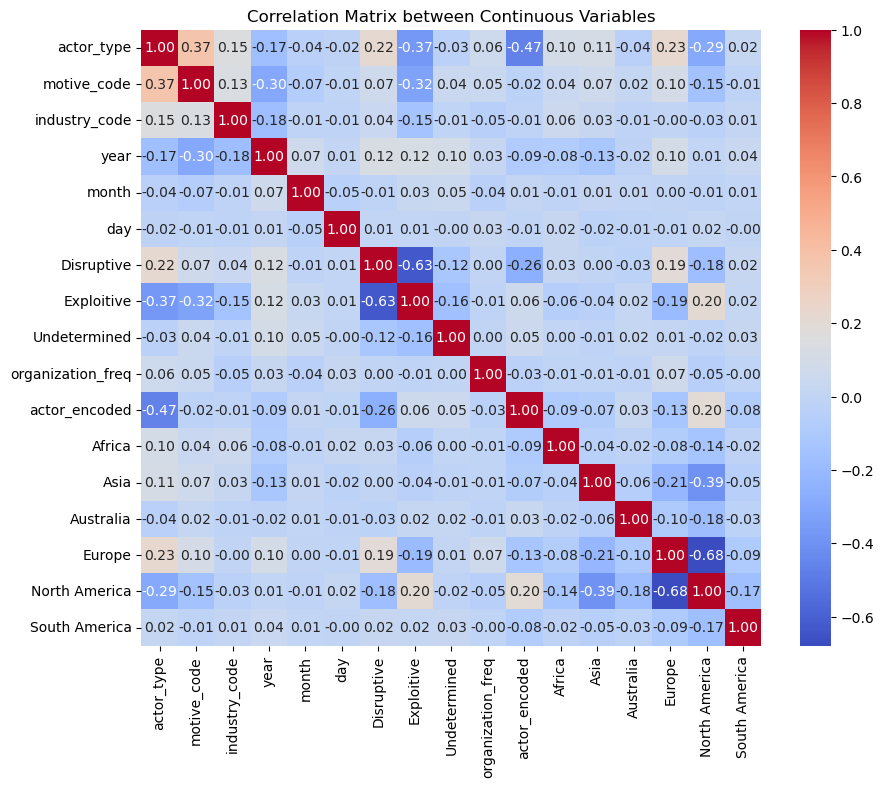

In [73]:
correlation_matrix = df_1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Continuous Variables')
plt.show()


# Gráficas generales

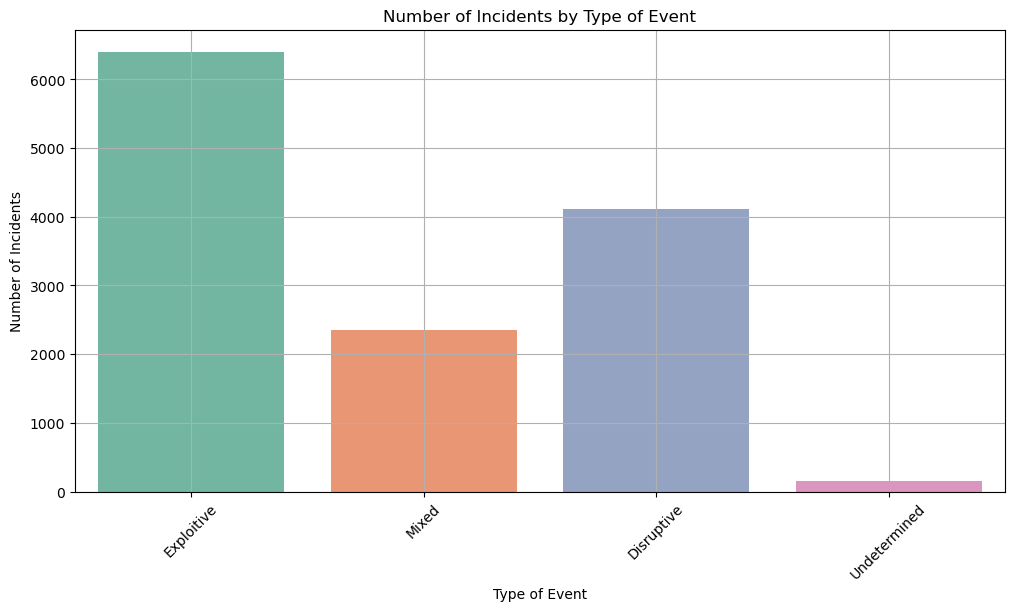

In [74]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='event_type', palette='Set2')
plt.title('Number of Incidents by Type of Event')
plt.xlabel('Type of Event')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid()
plt.show()

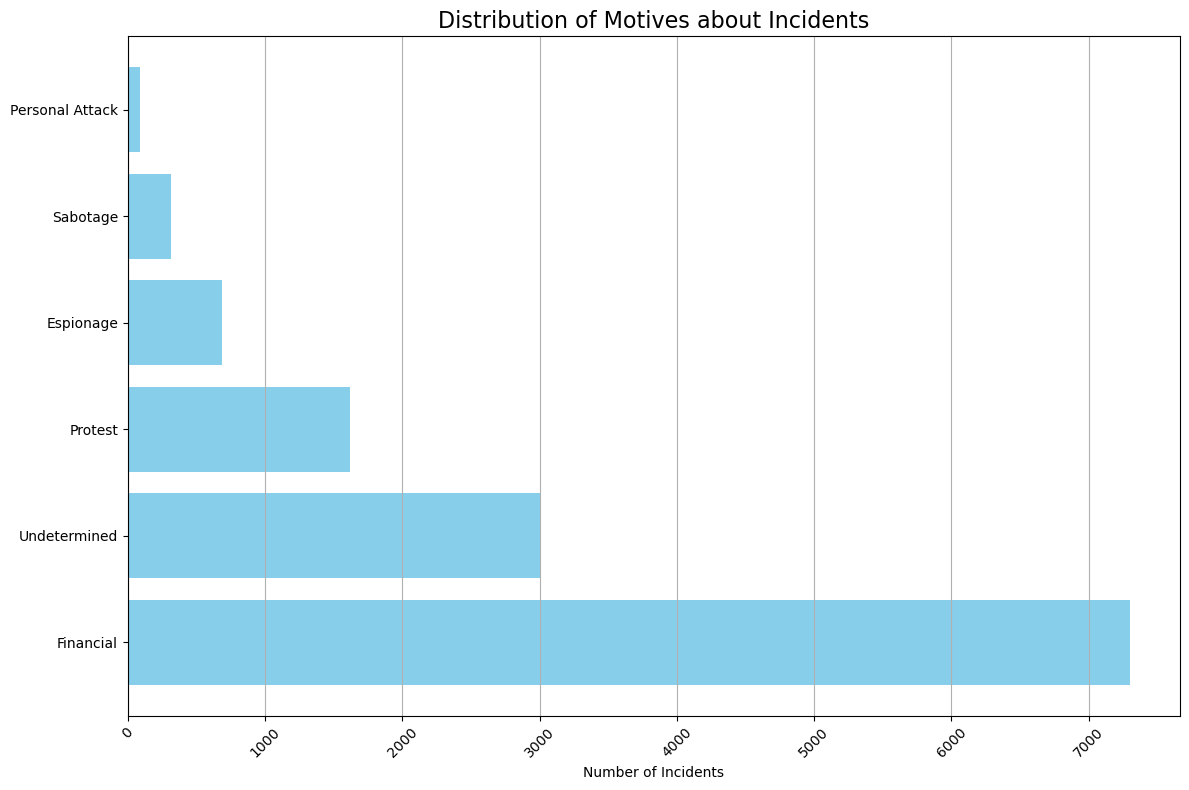

In [75]:
motive_counts = df['motive'].value_counts()
labels = motive_counts.index
sizes = motive_counts.values

plt.figure(figsize=(12, 8))
plt.barh(labels, sizes, color='skyblue')
plt.xlabel('Number of Incidents')
plt.title('Distribution of Motives about Incidents', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='x')

plt.tight_layout()
plt.show()

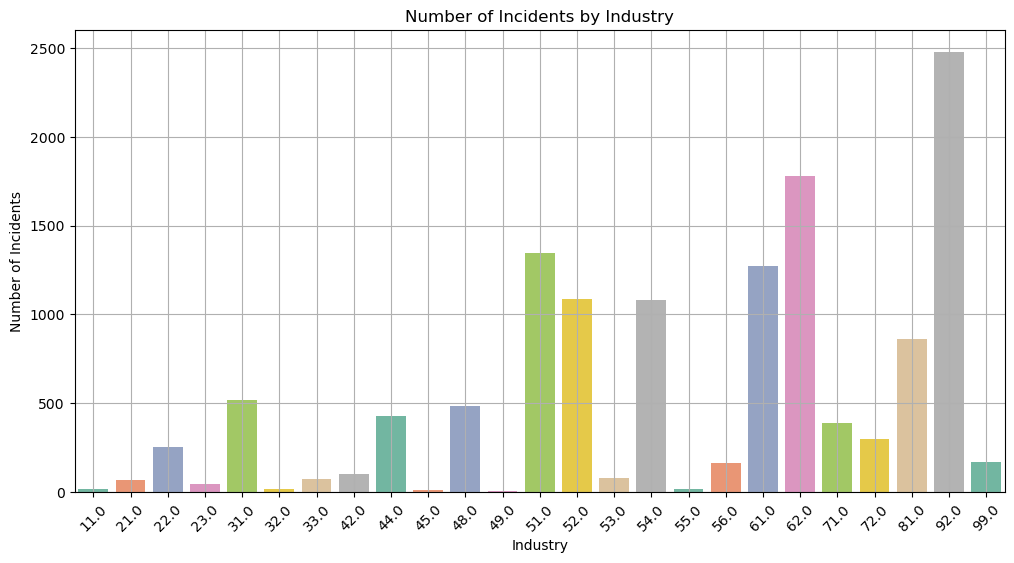

In [76]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='industry_code', palette='Set2')
plt.title('Number of Incidents by Industry')
plt.xlabel('Industry')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid()
plt.show()

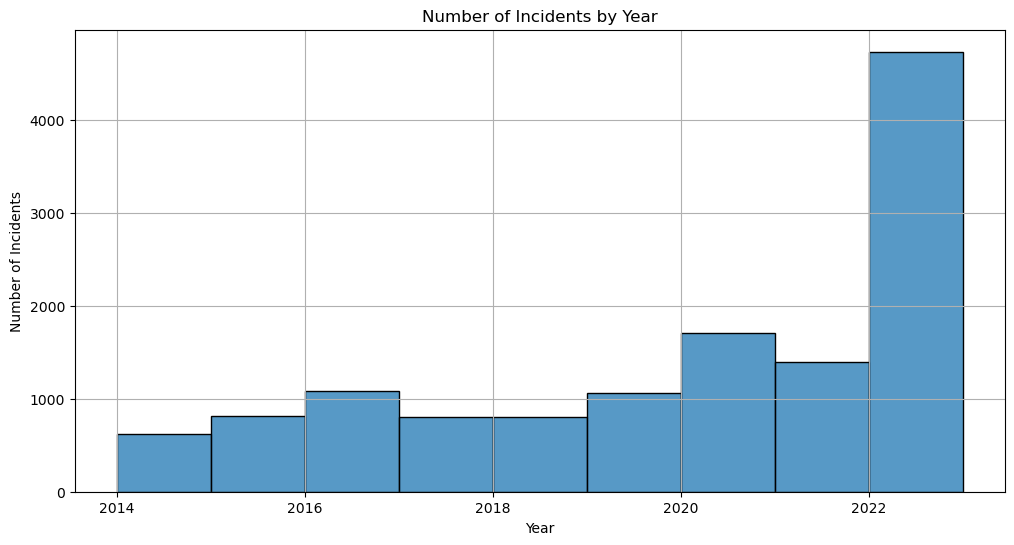

In [77]:
plt.figure(figsize=(12, 6))
sns.histplot(df['year'], bins=range(df['year'].min(), df['year'].max() + 1), kde=False)
plt.title('Number of Incidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid()
plt.show()